In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from utils import plot_contours

plt.rcParams["text.usetex"] = True
plt.rcParams["font.size"] = 14
torch.set_default_dtype(torch.double)

## Example 17: Box constraints 

We want to find the solution of the following quadratic optimization problem
$$
    \begin{aligned}
        \min_{\mathbf{x}} \quad & f(\mathbf{x})= (\mathbf{x}-\tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x}-\tilde{\mathbf{x}})\\
        \textrm{s.t.} \quad     & \mathbf{x}^l \le \mathbf{x} \le \mathbf{x}^u\\
    \end{aligned}
$$
with 
$$
    \mathbf{Q} = 
    \begin{pmatrix}
    2 & 1 \\
    1 & 1 
    \end{pmatrix}
    ,
    \tilde{\mathbf{x}} = 
    \begin{pmatrix}
    -1\\
    1 
    \end{pmatrix}
    ,
    \mathbf{x}^l = 
    \begin{pmatrix}
    0\\
    -2 
    \end{pmatrix}
    ,
    \mathbf{x}^u = 
    \begin{pmatrix}
    2\\
    2 
    \end{pmatrix}
    .
$$

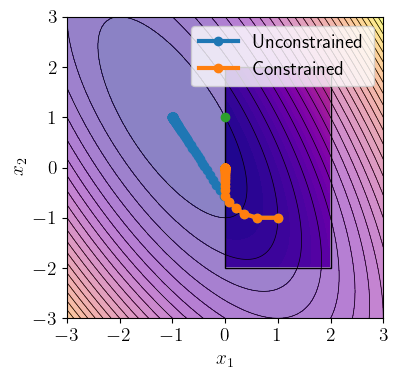

In [2]:
# Define domain
s = 3.0
x1 = torch.linspace(-s, s, steps=200)
x2 = torch.linspace(-s, s, steps=200)
x = torch.stack(torch.meshgrid(x1, x2, indexing="xy"), dim=2)


def f(x):
    """Define function."""
    xt = torch.tensor([-1.0, 1.0])
    Q = torch.tensor([[2.0, 1.0], [1.0, 1.0]])
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)



def simple_decent(x_init, func, eta=0.1, max_iter=100):
    """Simple decent from previous lectures and exercises (just copied)"""
    x = x_init.clone().requires_grad_()
    points = [x]
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        points.append(x)
    return points


def box_constrained_decent(x_init, func, x_lower, x_upper, eta=0.1, max_iter=100):
    """Box constrained decent"""
    x = x_init.clone().requires_grad_()

    points = [x]
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x).sum(), x)[0]
        x = x - eta * grad
        x = torch.clamp(x, x_lower, x_upper)
        points.append(x)
    return points


# Starting point
x_init = torch.tensor([1.0, -1.0])
# Lower bounds
x_lower = torch.tensor([0.0, -2.0])
# Upper bounds
x_upper = torch.tensor([2.0, 2.0])
# Optimization path of simple decent
path = simple_decent(x_init, f)
# Optimization path of constrained decent
path_pg = box_constrained_decent(x_init, f, x_lower, x_upper)

# Visualize paths
plot_contours(
    x[..., 0],
    x[..., 1],
    f(x),
    figsize=(4.2, 4.0),
    box=[x_lower, x_upper],
    paths={"Unconstrained": path, "Constrained": path_pg},
)
# This would be a clamped point
plt.plot([0], [1], marker="o", color="tab:green")
plt.xlim([-s, s])
plt.ylim([-s, s])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/box_example.svg", transparent=True)
plt.show()

## Example 18: Lagrange multipliers 

We want to find the solution of the following quadratic optimization problem for $\mathbf{x} \in \mathcal{R}^2$
$$
    \begin{aligned}
        \min_{\mathbf{x}} \quad & f(\mathbf{x})= (\mathbf{x}-\tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x}-\tilde{\mathbf{x}})\\
        \textrm{s.t.} \quad     & h(\mathbf{x}) = x_1 - x_2 - 2 = 0  \\
    \end{aligned}
$$
with 
$$
    \mathbf{Q} = 
    \begin{pmatrix}
    2 & 0 \\
    0 & 1 
    \end{pmatrix} 
    \quad 
    \text{and}
    \quad
    \tilde{\mathbf{x}} = 
    \begin{pmatrix}
    -1\\
    1 
    \end{pmatrix}.
$$

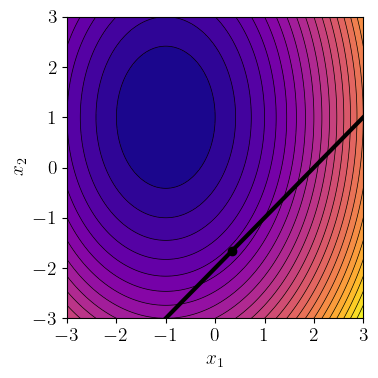

In [3]:
# Define function


def f(x):
    # Define constants
    xt = torch.tensor([-1.0, 1.0])
    Q = torch.tensor([[2.0, 0.0], [0.0, 1.0]])
    dx = x - xt
    return torch.einsum("...i,ij,...j", dx, Q, dx)


# Define equality constraint h(x) = 0 --> x_2 = x_1 - 2


def h(x1):
    return x1 - 2


# Plot problem
plot_contours(x[..., 0], x[..., 1], f(x), figsize=(4.0, 4.0))
plt.plot(x1, h(x1), "k", linewidth=3)
plt.plot([1 / 3], [-5 / 3], marker="o", color="k")
plt.xlim([-s, s])
plt.ylim([-s, s])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/lagrange_example.svg", transparent=True)
plt.show()

## Example 19: KKT conditions 1 

We want to find the solution of the following quadratic optimization problem for $\mathbf{x} \in \mathcal{R}^2$
$$
    \begin{aligned}
        \min_{\mathbf{x}} \quad & f(\mathbf{x})= (\mathbf{x}-\tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x}-\tilde{\mathbf{x}})\\
        \textrm{s.t.} \quad     & h(\mathbf{x}) = x_1 - x_2 - 2 = 0  \\
                        \quad     & g(\mathbf{x}) = x_1 + x_2 \le 0  \\
    \end{aligned}
$$
with 
$$
    \mathbf{Q} = 
    \begin{pmatrix}
    2 & 0 \\
    0 & 1 
    \end{pmatrix} 
    \quad 
    \text{and}
    \quad
    \tilde{\mathbf{x}} = 
    \begin{pmatrix}
    -1\\
    1 
    \end{pmatrix}.
$$

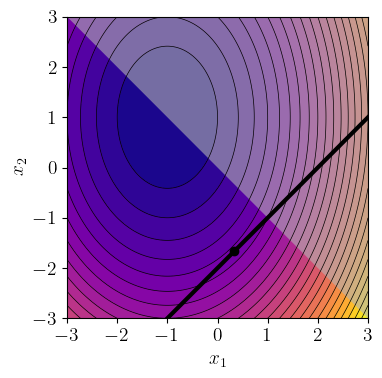

In [4]:
def g(x1):
    return -x1


plot_contours(x[..., 0], x[..., 1], f(x), figsize=(4.0, 4.0))
plt.plot(x1, h(x1), "k", linewidth=3)
plt.fill_between(x1, 5, g(x1), color=(0.7, 0.7, 0.7, 0.6), linewidth=0)
plt.plot([1 / 3], [-5 / 3], marker="o", color="k")
plt.xlim([-s, s])
plt.ylim([-s, s])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.savefig("../figures/kkt_example_1.svg", transparent=True)
plt.show()

## Example 20: KKT conditions 2

We want to find the solution of the following quadratic optimization problem for $\mathbf{x} \in \mathcal{R}^2$
$$
    \begin{aligned}
        \min_{\mathbf{x}} \quad & f(\mathbf{x})= (\mathbf{x}-\tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x}-\tilde{\mathbf{x}})\\
        \textrm{s.t.} \quad     & h(\mathbf{x}) = x_1 - x_2 - 2 = 0  \\
                        \quad     & g(\mathbf{x}) = -x_1 - x_2 \le 0  \\
    \end{aligned}
$$
with 
$$
    \mathbf{Q} = 
    \begin{pmatrix}
    2 & 0 \\
    0 & 1 
    \end{pmatrix} 
    \quad 
    \text{and}
    \quad
    \tilde{\mathbf{x}} = 
    \begin{pmatrix}
    -1\\
    1 
    \end{pmatrix}.
$$

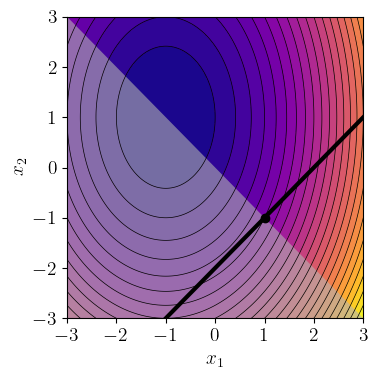

In [5]:
plot_contours(x[..., 0], x[..., 1], f(x), figsize=(4.0, 4.0))
plt.plot(x1, h(x1), "k", linewidth=3)
plt.fill_between(x1, -5, g(x1), color=(0.7, 0.7, 0.7, 0.6), linewidth=0)
plt.plot([1], [-1], marker="o", color="k")
plt.xlim([-s, s])
plt.ylim([-s, s])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/kkt_example_2.svg", transparent=True)
plt.show()

## Example 21: Dual problem
We want to find the solution of the following quadratic optimization problem for $\mathbf{x} \in \mathcal{R}^2$
$$
    \begin{aligned}
        \min_{\mathbf{x}} \quad & f(\mathbf{x})= (\mathbf{x}-\tilde{\mathbf{x}}) \cdot \mathbf{Q} \cdot (\mathbf{x}-\tilde{\mathbf{x}})\\
        \textrm{s.t.} \quad     & h(\mathbf{x}) = (x_1+1)^2 + x_2 = 0  \\
    \end{aligned}
$$
with 
$$
    \mathbf{Q} = 
    \begin{pmatrix}
    2 & 0 \\
    0 & 1 
    \end{pmatrix} 
    \quad 
    \text{and}
    \quad
    \tilde{\mathbf{x}} = 
    \begin{pmatrix}
    -1\\
    1 
    \end{pmatrix}.
$$

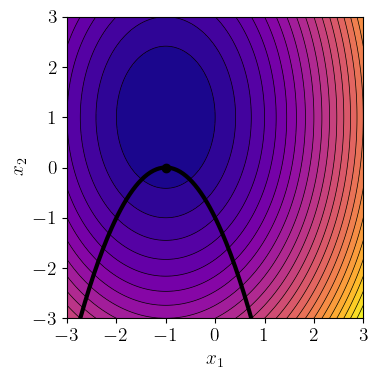

In [6]:
i = lambda x: -((x + 1) ** 2)

lbd_star = 2
x_star = -1
y_star = 1 - 1 / 2 * lbd_star

plot_contours(x[..., 0], x[..., 1], f(x), figsize=(4.0, 4.0))
plt.plot(x1, i(x1), "k", linewidth=3)
plt.plot([x_star], [y_star], marker="o", color="k")
plt.xlim([-s, s])
plt.ylim([-s, s])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/dual_example.svg", transparent=True)
plt.show()

## Example 22: Separable problem

Let's consider the previous example with the additional constraint $\mathbf{x} \in \mathcal{X} = [0, 2]\times[-2, 2]$.
This is visually equivalent to searching within the gray box for a point on the black line that has the smallest function value in the following image.

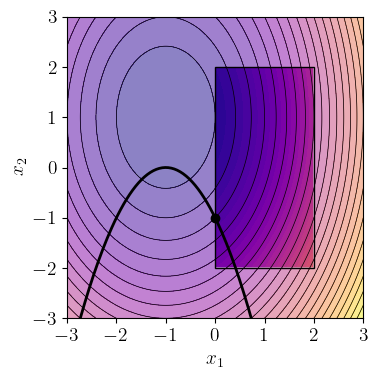

In [7]:
i = lambda x: -((x + 1) ** 2)


plot_contours(x[..., 0], x[..., 1], f(x), box=[x_lower, x_upper], figsize=(4.0, 4.0))
plt.plot(x1, i(x1), "k", linewidth=2)
plt.plot([0], [-1], marker="o", color="k")
plt.xlim([-s, s])
plt.ylim([-s, s])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.tight_layout()
plt.savefig("../figures/separable_example.svg", transparent=True)
plt.show()

Using the stationary points 
$$
    \frac{\partial \mathcal{L}_1}{\partial x_1} = 4\hat{x}_1+4+2\lambda \hat{x}_1 + 2 \lambda = 0 \\
    \frac{\partial \mathcal{L}_2}{\partial x_2} = 2\hat{x}_2-2+\lambda = 0
$$
we can solve 
$$
    x_1^*(\lambda) = \max(\min(\hat{x}_1(\lambda), x_1^u), x_1^l) = 0 \\
    x_2^*(\lambda) = \max(\min(\hat{x}_2(\lambda), x_2^u), x_2^l) = 
    \begin{cases}
        2 & \quad \lambda < -2 \\
        -2 & \quad \lambda > 6 \\
        1 - \frac{\lambda}{2} & \quad \text{else}
    \end{cases}
$$
and the dual objective function becomes 
$$
    \underline{\mathcal{L}}(\lambda) = 
    \begin{cases}
        3 + 3 \lambda  & \quad \lambda < -2 \\
        11 - \lambda  & \quad \lambda > 6 \\
        2 + 2 \lambda - \frac{\lambda^2}{4}   & \quad \text{else.}
    \end{cases}
$$

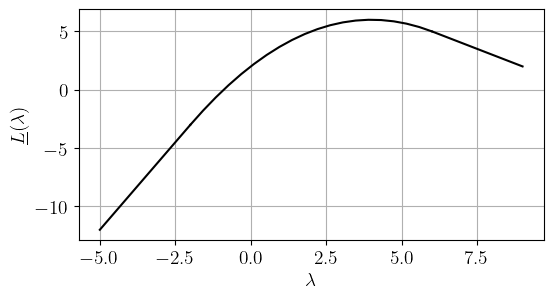

In [8]:
l_1 = np.linspace(-5, -2, 10)
l_2 = np.linspace(-2, 6, 20)
l_3 = np.linspace(6, 9, 10)
f_1 = 3 + 3 * l_1
f_2 = 2 + 2 * l_2 - l_2**2 / 4
f_3 = 11 - l_3

fig = plt.figure(figsize=(6, 3))
plt.plot(l_1, f_1, "k")
plt.plot(l_2, f_2, "k")
plt.plot(l_3, f_3, "k")
plt.xlabel("$\lambda$")
plt.ylabel("$\\underline{L}(\\lambda)$")
plt.grid()
plt.savefig("../figures/dual_function.svg", transparent=True)
plt.show()

In [9]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


# def saddle_function(x, y):
#     return x**2 - y**2

# x = np.linspace(-1, 1, 100)
# y = np.linspace(-1, 1, 100)
# xx, yy = np.meshgrid(x, y)
# z = saddle_function(xx, yy)

# fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "surface"}]])
# fig.add_trace(go.Contour(z=z, x=x, y=y, ncontours=25), row=1, col=1)
# fig.add_trace(go.Surface(z=z, x=xx, y=yy), row=1, col=2)
# fig.update_traces(showscale=False)
# fig.update_layout(autosize=False, width=1000, height=500)
# fig.show()